# Adversarial AttacksAnd Interpretability Covid Chestxray Dataset

Final Project - Cognitive Computing and Artificial Intelligence - UniCT a.a 2019/2020

*   Raiti Mario O55000434
*   Sortino Renato O55000405
*   Nardo Gabriele Salvatore O55000430

# Initial Setup

## Import Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os, random, torch, time, copy
import torch.nn.functional as F
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset
from PIL import Image, ImageOps, ImageFilter

In [2]:
!pip install captum

     |████████████████████████████████| 1.4MB 6.3MB/s 


## Enable Cuda for GPU computing

In [3]:
import torch
# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Create paths

In [4]:
# dataset_path = './dataset'
from os import path
from google.colab import drive
drive.mount("/content/drive")
#covid_dataset_path = "/content/drive/My Drive/Covid_Chestray_Dataset"
covid_dataset_path = "/content/drive/My Drive/Covid_Chestray_Dataset_Adversarial"

Mounted at /content/drive


# Data Preparation

## Creating a Dataset

In [5]:
classes = ['no-covid', 'covid']

In [6]:
class image_dataset(Dataset):
    """Class creator for the x-ray dataset."""

    def __init__(self, csv_path, root_dir, transform=None, phase=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = pd.read_csv(csv_path)
        self.root_dir = root_dir
        self.transform = transform
        # If not a PA view, drop the line 
        self.df.drop(self.df[self.df.view != 'PA'].index, inplace=True)
        # Allows to define different split ratios
        self.phase = phase

    def __len__(self):
        
        return len(self.df)

    def __getitem__(self, idx):
        '''
        Returns a dictionary that contains the image and the corresponding label
        '''
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        if self.df['finding'].iloc[idx] != 'COVID-19':
            finding = 0
            img_path = os.path.sep.join([covid_dataset_path, 'images', self.df['filename'].iloc[idx]])
            image = Image.open(img_path)
            sample = {'image': image, 'finding': finding}
            
            if self.transform:
                sample = {'image': self.transform[self.phase](sample['image']), 'finding': finding}

        else:
            finding = 1
            img_path = os.path.sep.join([covid_dataset_path, 'images', self.df['filename'].iloc[idx]])
            image = Image.open(img_path)
            sample = {'image': image, 'finding': finding}

            if self.transform:
                sample = {'image': self.transform[self.phase](sample['image']), 'finding': finding}

        return sample

## Creating the data transformations

In [7]:
# Data augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(3),
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(112),
        transforms.Resize(128),
        transforms.RandomCrop(112),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],
                             [0.25,0.25,0.25])
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(3),
        transforms.Resize(128),
        transforms.CenterCrop(112),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],
                             [0.25,0.25,0.25])
    ]),
}

## Create a train, validation and test dataset and the dataloaders

In order to apply the correct transformations to each subset, two copies of the same dataset have been produced, and then are splitted in the respective subsets.
Otherwise, we would have applied the train transformations (including random crop, random rotation...) to the validation dataset

In [8]:
from torch.utils.data import DataLoader, Subset
# Import images as Dataset
image_datasets = {
    x: image_dataset(
        csv_path=os.path.sep.join([covid_dataset_path, 'metadata.csv']),
        root_dir=covid_dataset_path,
        transform=data_transforms,
        phase=x)
    for x in ['train', 'test']
}

In [17]:
"""Ratio Train -> 70%, Val -> 15%, Test -> 15%"""
total_len = len(image_datasets['train'])

# Fractions
train_frac = 0.7
val_frac = 0.15
test_frac = 0.15
# Compute number of samples
num_train = int(total_len * train_frac)
num_val = int(total_len * val_frac)
num_test = int(total_len * test_frac)
# Indexes 
indexes = list(range(total_len))
# Split training set
train_idx = indexes[:num_train]
val_idx = indexes[num_train : num_train + num_val]
test_idx = indexes[num_train + num_val:]

In [18]:
#Create train , val and test dataset and loaders as subset of image dataset
train_dataset = Subset(image_datasets['train'], train_idx)
val_dataset = Subset(image_datasets['test'], val_idx)
test_dataset = Subset(image_datasets['test'], test_idx)

train_loader = DataLoader(train_dataset, batch_size=8, num_workers=4, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=8, num_workers=4, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=8, num_workers=4, shuffle=False)

loaders = {"train": train_loader,
           "val": val_loader,
           "test": test_loader}

dataset_sizes = {x: len(loaders[x].dataset) for x in ['train', 'val', 'test']}

# Model definition and training

## Create a train method

In [19]:
def train_model(model, criterion, optimizer, scheduler, loaders, num_epochs=25, device='cpu'):
    since = time.time()

    # Save best performance model weights during training
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    try:
        for epoch in range(num_epochs):
            sum_loss = {"train": 0, "val": 0, "test": 0}
            sum_accuracy = {"train": 0, "val": 0, "test": 0}
            print('Epoch {}/{}'.format(epoch+1, num_epochs))
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val', 'test']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                # Iterate over data.
                for data in loaders[phase]:
                    inputs = data['image']
                    labels = data['finding']
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    # zero the parameter gradients
                    optimizer.zero_grad()
                    # forward
                    # track history if only in train
                    # with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    loss = criterion(preds.float(), labels.float())
                    # Test to check if model 
                    loss.requires_grad = True
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    # statistics
                    sum_loss[phase] += loss.item() * inputs.size(0)              
                    sum_accuracy[phase] += torch.sum(preds == labels.data)

                epoch_loss = sum_loss[phase] / dataset_sizes[phase]
                epoch_acc = sum_accuracy[phase].double() / dataset_sizes[phase]

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

            epoch_loss_phase = {split: sum_loss[split]/dataset_sizes[split] for split in ["train", "val", "test"]}
            epoch_accuracy_phase = {split: sum_accuracy[split].double()/dataset_sizes[split] for split in ["train", "val", "test"]} 

            for split in ["train", "val", "test"]:
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(split, epoch_loss_phase[split], epoch_accuracy_phase[split]))
                history_loss[split].append(epoch_loss_phase[split])
                history_accuracy[split].append(epoch_accuracy_phase[split])
                print('-' * 30)
    except KeyboardInterrupt:
        print(f"Computation Stopped at epoch : {epoch+1}")
    except Exception as e:
        print(e)
    finally:
        time_elapsed = time.time() - since
        print("-----------------------------------------")
        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best validation Acc: {:4f}'.format(best_acc))
        # load best model weights
        model.load_state_dict(best_model_wts)
        return model

## Case 1: From Scratch model training

### Define Model

In [20]:
# Imports
import torch.nn as nn
import torch.nn.functional as F

# Define model
class ModelFromScratch(nn.Module):
    def __init__(self):
        
        super().__init__();

        self.conv_layers = nn.Sequential(
            # Layer 1
            nn.Conv2d(3, 64, kernel_size=3, padding=0, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            # Layer 2
            nn.Conv2d(64, 128, kernel_size=3, padding=0, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            # Layer 3
            nn.Conv2d(128, 128, kernel_size=3, padding=0, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            # Layer 4
            nn.Conv2d(128, 256, kernel_size=3, padding=0, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            # Layer 5
            nn.Conv2d(256, 256, kernel_size=3, padding=0, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            # Layer 6
            nn.Conv2d(256, 256, kernel_size=3, padding=0, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            # Layer 7
            nn.Conv2d(256, 512, kernel_size=3, padding=0, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            # Layer 8
            nn.Conv2d(512, 512, kernel_size=3, padding=0, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Layer 9
            nn.Conv2d(512, 1024, kernel_size=3, padding=0, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(1024),
            nn.MaxPool2d(kernel_size=4, stride=4),
        )

        self.fc_layers = nn.Sequential(
            # FC layer
            nn.Linear(1024, 128),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(128, 16),
            nn.Dropout(0.5),
            nn.ReLU(),
            # Classification layer
            nn.Linear(16, len(classes))
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [21]:
# Create model
model_fs = ModelFromScratch()

# Test model output
model_fs.eval()
print(train_dataset.dataset)
test_input = train_dataset[0]['image'].unsqueeze(0)
print("Model output size:", model_fs(test_input).size())

# Move model to device
model_fs = model_fs.to(device)

Model output size: torch.Size([1, 2])


### Train model

In [22]:
#criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()

# Note that we are only training the head.
optimizer_ft = optim.Adam(model_fs.parameters(), lr=1e-7)

In [23]:
history_loss = {"train": [], "val": [], "test": []}
history_accuracy = {"train": [], "val": [], "test": []}

In [24]:
model_fs_trained = train_model(model_fs.to(device), criterion, optimizer_ft, None, loaders, num_epochs=50, device=device)

Epoch 1/50
----------
train Loss: 0.6477 Acc: 0.4481
------------------------------
val Loss: 0.6931 Acc: 0.5111
------------------------------
test Loss: 0.6931 Acc: 0.4783
------------------------------
Epoch 2/50
----------
train Loss: 0.6871 Acc: 0.3443
------------------------------
val Loss: 0.7252 Acc: 0.5111
------------------------------
test Loss: 0.7671 Acc: 0.4348
------------------------------
Epoch 3/50
----------
train Loss: 0.6526 Acc: 0.4292
------------------------------
val Loss: 0.7296 Acc: 0.5556
------------------------------
test Loss: 0.7206 Acc: 0.5435
------------------------------
Epoch 4/50
----------
train Loss: 0.6438 Acc: 0.4434
------------------------------
val Loss: 0.7887 Acc: 0.4000
------------------------------
test Loss: 0.6989 Acc: 0.5870
------------------------------
Epoch 5/50
----------
train Loss: 0.6757 Acc: 0.3774
------------------------------
val Loss: 0.7856 Acc: 0.4222
------------------------------
test Loss: 0.7123 Acc: 0.5652
------

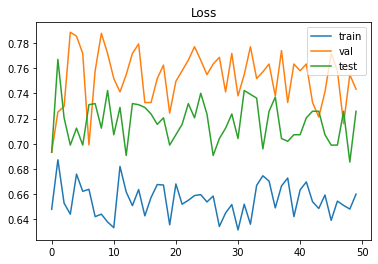

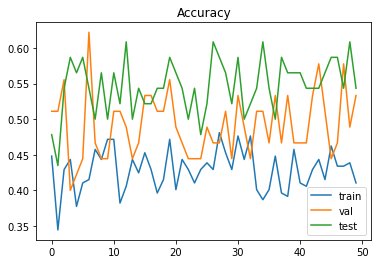

In [25]:
# Plot loss history
plt.title("Loss")
for split in ["train", "val", "test"]:
  plt.plot(history_loss[split], label=split)
plt.legend()
plt.show()

# Plot accuracy history
plt.title("Accuracy")
for split in ["train", "val", "test"]:
  plt.plot(history_accuracy[split], label=split)
plt.legend()
plt.show()

# Adversarial attack FGSM



## Case 2 : Adversarial Training

### Creating Adversarial Dataloader

In [ ]:
from torch.utils.data import ConcatDataset

In [ ]:
covid_adversarial_path = "/content/drive/My Drive/Covid_Chestray_Dataset_Adversarial/adv"


img_dataset_adv = {
    x: image_dataset(
        csv_path=os.path.sep.join([covid_adversarial_path, 'metadata.csv']),
        root_dir=covid_adversarial_path,
        transform=data_transforms,
        phase=x)
    for x in ['train', 'test']
}

train_dataset_adv = Subset(img_dataset_adv['train'], train_idx)
val_dataset_adv = Subset(img_dataset_adv['test'], val_idx)
test_dataset_adv = Subset(img_dataset_adv['test'], test_idx)

train_loader_adv = DataLoader(
             ConcatDataset(
                 [train_dataset,
                 train_dataset_adv]
             ),
             batch_size= 8, shuffle=True,
             num_workers= 4)

val_loader_adv = DataLoader(
             ConcatDataset(
                 [val_dataset,
                 val_dataset_adv]
             ),
             batch_size= 8, shuffle=True,
             num_workers= 4)

test_loader_adv = DataLoader(
             ConcatDataset(
                 [test_dataset,
                 test_dataset_adv]
             ),
             batch_size= 8, shuffle=True,
             num_workers= 4)

In [ ]:
loaders_adv = {"train": train_loader_adv,
           "val": val_loader_adv,
           "test": test_loader_adv}

dataset_sizes_adv = {x: len(loaders_adv[x].dataset) for x in ['train', 'val', 'test']}

### Training and Fine tuning

In [ ]:
#criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()

# Note that we are only training the head.
optimizer_ft = optim.Adam(model_fs.parameters(), lr=1e-6)

In [ ]:
history_loss = {"train": [], "val": [], "test": []}
history_accuracy = {"train": [], "val": [], "test": []}

In [ ]:
model_fs_attack = train_model(model_fs_trained.to(device), criterion, optimizer_ft, None, loaders_adv, num_epochs=50, device=device)

NameError: ignored

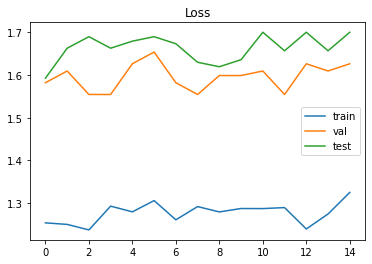

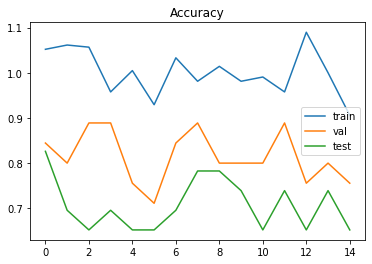

In [ ]:
# Plot loss history
plt.title("Loss")
for split in ["train", "val", "test"]:
  plt.plot(history_loss[split], label=split)
plt.legend()
plt.show()

# Plot accuracy history
plt.title("Accuracy")
for split in ["train", "val", "test"]:
  plt.plot(history_accuracy[split], label=split)
plt.legend()
plt.show()

## Interpretability

## Interpretability Function

In [ ]:
def modelInterpretation(device, model, idx):
    '''
    Returns interpretability value for the specified model
    idx is used to take the same image between two models, in order to make a 
    comparison
    '''
  # Model interpretability
  import random
  from captum.attr import IntegratedGradients
  from captum.attr import visualization as viz
  from matplotlib.colors import LinearSegmentedColormap
  %matplotlib inline

  # Get random sample from test set
  input, label = loaders['test'].dataset[idx]['image'], loaders['test'].dataset[idx]['finding']
  # Normalize and show image
  input_show = (input - input.min())/(input.max() - input.min())
  plt.imshow(input_show.permute(1,2,0).numpy())
  plt.title("Original Image")
  plt.axis('off')
  # Predict class
  model.eval()
  output = model(input.unsqueeze(0).to(device))
  _,pred = output.max(1)
  pred = pred.item()
  output_probs = F.softmax(output, dim=1)

  # Compute feature importance
  integrated_gradients = IntegratedGradients(model.to(device))
  input = input.to(device)

  attributions_ig = integrated_gradients.attribute(input.unsqueeze(0).to(device), target=pred)

  default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                  [(0, '#ffffff'),
                                                    (0.25, '#000000'),
                                                    (1, '#000000')], N=256)

  _= viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                              np.transpose(input.squeeze().cpu().detach().numpy(), (1,2,0)),
                              method='heat_map',
                              cmap=default_cmap,
                              show_colorbar=True,
                              sign='positive',
                              outlier_perc=1,
                              title="Integrated Gradient Interpretability")
  return attributions_ig

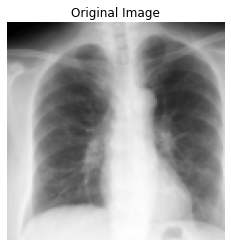

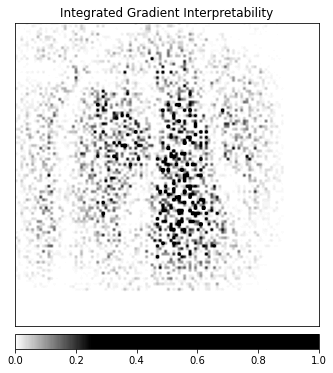

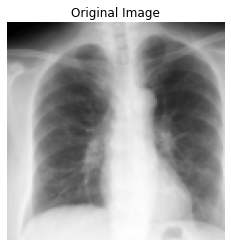

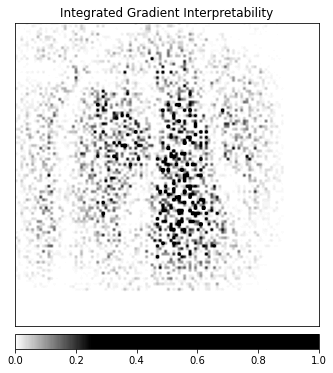

In [ ]:
idx = 7
attr = modelInterpretation(device, model_fs_trained, idx)

attr_attack = modelInterpretation(device, model_fs_attack, idx)

In [ ]:
confronto = attr - attr_attack
print(confronto.abs())

In [31]:
dataloader = torch.utils.data.DataLoader(image_datasets['test'], batch_size=(len(image_datasets['test'])), num_workers=8)

dataiter = iter(dataloader)
data = dataiter.next()
images = data['image']
labels = data['finding']

model_fs_trained.to('cpu')

output = torch.tensor(model_fs_trained(images).detach().numpy())

Confusion matrix, without normalization
[[ 52  50]
 [108  93]]
[[ 52 108]
 [ 50  93]]
acc: 0.4785
sensitivity: 0.5098
specificity: 0.4627


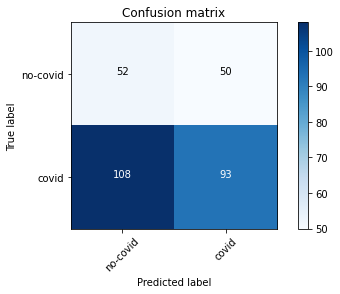

In [47]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(i, j, format(cm[j, i], fmt), horizontalalignment="center", color="white" if cm[j,i] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

from sklearn.metrics import confusion_matrix

# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(labels, np.argmax(output,1))
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
#classes = ['covid', 'no-covid']
classes = ['no-covid', 'covid']
plot_confusion_matrix(cm, classes)
# show the confusion matrix, accuracy, sensitivity, and specificity
print(np.transpose(cm, (1,0)))
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

## Adversarial Image Creation

In [ ]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [ ]:
from torchvision.utils import save_image

epsilon = 0.025
covid_adv_path = path.join("/content/drive/My Drive/", "Covid_Chestray_Dataset_Adversarial/adv_images")

img_dataset = image_dataset(
        csv_path=os.path.sep.join([covid_dataset_path, 'metadata.csv']),
        root_dir=covid_dataset_path,
        transform= {'train': transforms.Compose([
          transforms.Grayscale(3),
          transforms.Resize(240),
          transforms.CenterCrop(224),
          transforms.ToTensor(),
    ])},
    phase='train')

train_dataset = Subset(img_dataset, train_idx)
val_dataset = Subset(img_dataset, val_idx)
test_dataset = Subset(img_dataset, test_idx)
train_loader = DataLoader(train_dataset, batch_size=1, num_workers=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, num_workers=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, num_workers=4, shuffle=True)
print(len(train_loader))
loaders = {"train": train_loader,
           "val": val_loader,
           "test": test_loader}

212


In [ ]:
metadata_path = path.join("/content/drive/My Drive/", "Covid_Chestray_Dataset_Adversarial/adv_metadata.csv")

df = pd.DataFrame([], columns=['filename', 'finding'])


In [ ]:
for loader in loaders:
  for i, datas in enumerate(loaders[loader]):

      data = datas['image']
      target = datas['finding']

      # Send the data and label to the device
      data, target = data.to(device).requires_grad_(), target.to(device)

      # Set requires_grad attribute of tensor. Important for Attack
      data.requires_grad = True

      # Forward pass the data through the model
      output = model_fs_trained(data)

      # Calculate the loss
      loss = F.nll_loss(output, target)

      # Zero all existing gradients
      model_fs_trained.zero_grad()

      # Calculate gradients of model in backward pass
      loss.backward()

      # Collect datagrad
      data_grad = data.grad.data

      # Call FGSM Attack
      perturbed_data = fgsm_attack(data, epsilon, data_grad)
      img_name = loader + "_adv_img" + str(i) + ".png"

      if target == 0:
        finding = 'COVID-19'
      else:
        finding = 'NO-COVID-19'

      new_row = {'filename': img_name, 'finding':finding}
      df = df.append(new_row, ignore_index=True)

      save_image(perturbed_data, path.join(covid_adv_path, img_name))
  df.to_csv(metadata_path)